In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *

In [2]:

# Function to parse video and extract frames around a specific timestamp
def extract_video_clip(video_path, target_timestamp, video_start_time,time_window=2):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None
    # Get video frame rate and total frame count
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame range for the +- time_window
    target_time = target_timestamp
    start_time = target_time - timedelta(seconds=time_window)
    end_time = target_time + timedelta(seconds=time_window)
    if start_time < video_start_time:
        start_time = video_start_time
    if end_time > video_start_time + timedelta(seconds=total_frames / fps):
        end_time = video_start_time + timedelta(seconds=total_frames / fps)
    # print(f"Target Time: {target_time}, Start Time: {start_time}, End Time: {end_time}")
    # Extract frames within the time range
    frames = []
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Calculate the timestamp for the current frame
        frame_time = video_start_time + timedelta(seconds=frame_index / fps)
        if start_time <= frame_time <= end_time:
            frames.append(frame)
        frame_index += 1
        if frame_time > end_time:
            break

    cap.release()
    return np.array(frames)

# Load Excel file
def load_excel_data(file_path):
    activation_df = pd.read_excel(file_path, sheet_name="Activation")
    non_activation_df = pd.read_excel(file_path, sheet_name="NonActivation")
    return activation_df, non_activation_df

# Function to process dataset and extract video clips
def process_dataset(video_dir, excel_file, output_dir, clip_save_dir, time_window=3):
    # Load the Excel data
    activation_df, non_activation_df = load_excel_data(excel_file)

    # Create directories for saving data
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(clip_save_dir, exist_ok=True)

    # Prepare data for activation and non-activation
    # all_data = []
    for df, label in [(activation_df, 1), (non_activation_df, 0)]:
        for _, row in tqdm(df.iterrows()):
            clip_timestamp = row["timestamp"]
            location = row["location"]
            # convert to datetime object
            clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
            # Match the video file with the timestamp
            for video_file in os.listdir(video_dir):
                video_start_timestamp = video_file[22:].split(".")[0]
                # convert to datetime object
                video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
                video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
                if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                    video_path = os.path.join(video_dir, video_file)
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                    if os.path.exists(clip_save_path):
                        continue
                    # Extract video clip
                    frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                    if frames is not None:
                        data = (frames, label, row["timestamp"], location)
                        # save the clip to the clip_save_dir
                        # clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                        torch.save(torch.tensor(frames), clip_save_path)



In [4]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file = r"D:\LiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file)

# Create directories for saving data
os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(clip_save_dir, exist_ok=True)

# Prepare data for activation and non-activation
# all_data = []
for df, label in [(activation_df, 1), (non_activation_df, 0)]:
    for _, row in tqdm(df.iterrows()):
        clip_timestamp = row["timestamp"]
        location = row["location"]
        # convert to datetime object
        clip_timestamp = datetime.strptime(clip_timestamp, "%Y%m%d_%H%M%S")
        # Match the video file with the timestamp
        for video_file in os.listdir(video_dir):
            video_start_timestamp = video_file[22:].split(".")[0]
            # convert to datetime object
            video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
            video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
            if video_start_timestamp <= clip_timestamp <= video_end_timestamp:
                video_path = os.path.join(video_dir, video_file)
                clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.pt")
                if os.path.exists(clip_save_path):
                    continue
                # Extract video clip
                frames = extract_video_clip(video_path, clip_timestamp, video_start_timestamp,time_window)
                if frames is not None:
                    data = (frames, label, row["timestamp"], location)
                    # save the clip to the clip_save_dir
                    clip_save_path = os.path.join(clip_save_dir, f"{label}_{row['timestamp']}_{location}.mp4")
                    out = cv2.VideoWriter(clip_save_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frames.shape[2], frames.shape[1]))
                    for frame in frames:
                        out.write(frame)
                    out.release()
# process_dataset(video_dir, excel_file, output_dir,clip_save_dir, time_window=3)

120it [27:08, 13.57s/it]
402it [1:31:02, 13.59s/it]


In [9]:
# Split the dataset into train, validation with 80% and 20% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
train_clips, val_clips = train_test_split(clips, test_size=0.2, random_state=714)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
val_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\val'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
# Move the clips to the respective folders
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    os.rename(src, dst)
for clip in val_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(val_folder, clip)
    os.rename(src, dst)

In [2]:
def create_data_loaders(train_dir, val_dir, batch_size=8, transform=None):
    train_dataset = VideoDataset(train_dir, transform=transform)
    val_dataset = VideoDataset(val_dir, transform=transform)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [23]:
data_set_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset'
train_loader, val_loader = create_data_loaders(
        train_dir=os.path.join(data_set_dir, "train"),
        val_dir=os.path.join(data_set_dir, "val"),
        # test_dir=os.path.join(output_directory, "test"),
        batch_size=4,
        transform=None
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [ ]:
for i, (frames, labels, locations) in enumerate(train_loader):
    print(frames.shape, labels)
    break

torch.Size([4, 61, 300, 700, 3]) tensor([0, 0, 1, 0])


In [34]:

labels

tensor([0, 0, 1, 0])

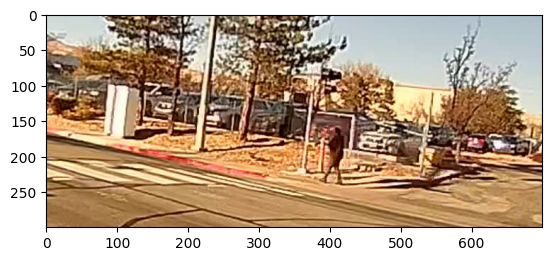

In [39]:
test_img = frames[2][33].to("cpu").numpy().astype(np.uint8)
plt.imshow(test_img)
plt.show()

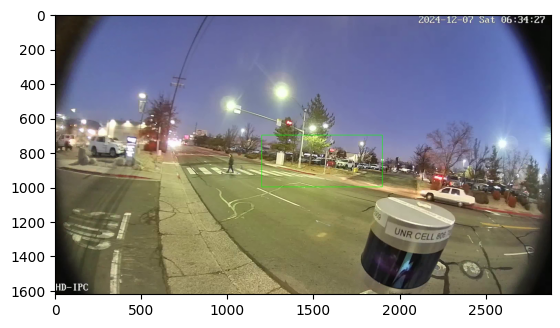

In [37]:
test_img = frames[0][2].to("cpu").numpy().astype(np.uint8)
# plt.imshow(test_img)
# plot a box in xmin, ymin, xmax, ymax format
xmin, ymin, xmax, ymax = 1200, 700, 1200 + width, 700 + height
cv2.rectangle(test_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.imshow(test_img)
plt.show()